# Unified Query Projection with Optional Residual Adapters

## Comparing Fast vs Adaptive Domain Alignment

This notebook demonstrates ScAdver's **unified projection approach** with two modes:

1. **Fast Mode** (`adapter_dim=0`) - Direct projection
2. **Adaptive Mode** (`adapter_dim>0`) - Residual adapter for domain shifts

**When to use Fast Mode (adapter_dim=0):**
- Similar protocols (e.g., 10X v2 → 10X v3)
- Processing many batches (speed critical)
- Real-time applications

**When to use Adaptive Mode (adapter_dim>0):**
- Large domain shift (e.g., 10X → Smart-seq2)
- Different tissue types or experimental conditions
- Quality matters more than speed

**Key Insight**: When adapter_dim>0 but domains are similar, the adapter automatically learns to stay near zero, making it equivalent to fast mode.

In [1]:
# Import libraries
import numpy as np
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import time
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd

from scadver import adversarial_batch_correction, transform_query_adaptive

print("✅ Libraries imported successfully!")
print(f"📦 Scanpy version: {sc.__version__}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✅ Libraries imported successfully!
📦 Scanpy version: 1.11.4
🔥 PyTorch version: 2.8.0
🖥️  Device: MPS


## 📊 Step 1: Load Pancreas Dataset with Domain Shift

We'll use the real pancreas dataset with:
- **Reference**: All technologies except smartseq2 and celseq2
- **Query**: smartseq2 + celseq2 

In [5]:
# Load pancreas dataset
print("Loading pancreas dataset...")

adata = sc.read("human_pancreas_norm_complexBatch.h5ad")

print(f"✅ Loaded dataset: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"📊 Technologies: {adata.obs['tech'].unique()}")
print(f"🧬 Cell types: {adata.obs['celltype'].unique()}")

# Preprocess - select highly variable genes
print("\n🔄 Preprocessing data...")
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="tech", subset=True)
print(f"✅ Selected {adata.shape[1]} highly variable genes")

# Split into reference and query 
# Query: smartseq2 and celseq2
query_techs = ['smartseq2', 'celseq2']
adata_query = adata[adata.obs['tech'].isin(query_techs)].copy()

# Reference: everything else
adata_ref = adata[~adata.obs['tech'].isin(query_techs)].copy()

print(f"\n📊 Data Split:")
print(f"   Reference: {adata_ref.shape[0]} cells")
print(f"   Technologies: {adata_ref.obs['tech'].value_counts().to_dict()}")
print(f"\n   Query: {adata_query.shape[0]} cells ({', '.join(query_techs)})")
print(f"   Technologies: {adata_query.obs['tech'].value_counts().to_dict()}")
print(f"\n   Total: {adata_ref.shape[0] + adata_query.shape[0]} cells")
print(f"\n🧬 Cell type distribution in reference:")
print(adata_ref.obs['celltype'].value_counts())
print(f"\n🧬 Cell type distribution in query:")
print(adata_query.obs['celltype'].value_counts())

Loading pancreas dataset...
✅ Loaded dataset: 16382 cells × 19093 genes
📊 Technologies: ['celseq', 'celseq2', 'fluidigmc1', 'smartseq2', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'smarter']
Categories (9, object): ['celseq', 'celseq2', 'fluidigmc1', 'inDrop1', ..., 'inDrop3', 'inDrop4', 'smarter', 'smartseq2']
🧬 Cell types: ['gamma', 'acinar', 'alpha', 'delta', 'beta', ..., 'mast', 'macrophage', 'epsilon', 'quiescent_stellate', 't_cell']
Length: 14
Categories (14, object): ['acinar', 'activated_stellate', 'alpha', 'beta', ..., 'mast', 'quiescent_stellate', 'schwann', 't_cell']

🔄 Preprocessing data...
✅ Selected 2000 highly variable genes

📊 Data Split:
   Reference: 11703 cells
   Technologies: {'inDrop3': 3605, 'inDrop1': 1937, 'inDrop2': 1724, 'smarter': 1492, 'inDrop4': 1303, 'celseq': 1004, 'fluidigmc1': 638}

   Query: 4679 cells (smartseq2, celseq2)
   Technologies: {'smartseq2': 2394, 'celseq2': 2285}

   Total: 16382 cells

🧬 Cell type distribution in reference:
celltype
alp

## Step 2: Train ScAdver on Reference Data

In [6]:
%%time
# Train on reference data
adata_ref_corrected, model, ref_metrics = adversarial_batch_correction(
    adata=adata_ref,
    bio_label='celltype',
    batch_label='tech',
    latent_dim=256,
    epochs=50,
    device='mps',
    bio_weight=20.0
)

print(f"\n✅ Reference training complete!")
print(f"   Biology preservation: {ref_metrics['biology_preservation']:.4f}")
print(f"   Batch correction: {ref_metrics['batch_correction']:.4f}")
print(f"   Overall score: {ref_metrics['overall_score']:.4f}")

🚀 ADVERSARIAL BATCH CORRECTION
   Device: mps
📊 DATA PREPARATION:
   Valid samples: 11703/11703
   Input shape: (11703, 2000)
   Biology labels: 14 unique
   Batch labels: 7 unique
   Standard batch correction (no reference-query split)
🧠 MODEL ARCHITECTURE:
   Input dimension: 2000
   Latent dimension: 256
   Biology classes: 14
   Batch classes: 7
🏋️ TRAINING MODEL:
   Epochs: 50
   Learning rate: 0.001
   Bio weight: 20.0
   Batch weight: 0.5
✅ Training completed! Best biology accuracy: 0.000
🔄 GENERATING CORRECTED EMBEDDING:
   Output embedding shape: (11703, 256)
   💡 Tip: Set return_reconstructed=True to get batch-corrected gene expression matrix
📊 CALCULATING PERFORMANCE METRICS:


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-package

   Biology preservation: 0.6719
   Batch correction: 1.1127
   Overall score: 0.8482
🎉 ADVERSARIAL BATCH CORRECTION COMPLETE!
   Latent embedding: adata_corrected.obsm['X_ScAdver'] (shape: (11703, 256))

✅ Reference training complete!
   Biology preservation: 0.6719
   Batch correction: 1.1127
   Overall score: 0.8482
CPU times: user 1min 15s, sys: 11.1 s, total: 1min 26s
Wall time: 1min 18s


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


##  Step 3: Project Query Data - Compare Methods

### Method 1: Fast Projection (adapter_dim=0, default)

In [7]:
%%time
# Fast projection (adapter_dim=0, default - no adaptation)
adata_query_standard = transform_query_adaptive(
    model=model,
    adata_query=adata_query,
    adapter_dim=0,  # Default: no residual adapter, direct projection
    device='mps'
)

🚀 FAST QUERY PROJECTION (Direct)
   Device: mps
   Query samples: 4679
   Mode: Fast direct projection (adapter_dim=0)
   ⚡ No adaptation - using frozen encoder only

🔄 Projecting through frozen encoder...
   ✅ Encoder weights: FROZEN
   ✅ No adaptation: Output = encoder(x)
✅ Projection complete!
   Output embedding shape: (4679, 256)
CPU times: user 21.6 ms, sys: 20.4 ms, total: 41.9 ms
Wall time: 132 ms


### Method 2: Adaptive Projection (adapter_dim>0, with residual adapter)

In [8]:
%%time
# Adaptive projection (adapter_dim=128 enables residual adapter for domain shift)
adata_query_adaptive = transform_query_adaptive(
    model=model,
    adata_query=adata_query,
    adata_reference=adata_ref,  # Required for adaptation: reference sample for alignment
    bio_label='celltype',  # Optional: supervised adaptation with biological labels
    adapter_dim=128,  # Enable residual adapter (>0 triggers adaptation)
    adaptation_epochs=30,  # Train adapter for 30 epochs
    device='mps'
)

🔬 ADAPTIVE QUERY PROJECTION (Domain Adaptation)
   Device: mps
   Query samples: 4679
   Mode: Adaptive projection (adapter_dim=128)
   Adaptation epochs: 30

🏗️  Initializing residual adapter...
   Architecture: latent_dim → 128 → latent_dim
   Reference samples for alignment: 11703
   Biological supervision: celltype (13 classes)

🏋️  Training residual adapter...
   Strategy: Adversarial domain alignment + biological preservation
   Epoch 1/30 - Disc: 1.3556, Adapter: 1.7463
      💾 New best adapter saved!
   Epoch 10/30 - Disc: 0.9723, Adapter: 1.9083
   Epoch 20/30 - Disc: 1.0153, Adapter: 1.8754
   Epoch 30/30 - Disc: 0.9666, Adapter: 2.0348
✅ Adaptation complete! Best alignment loss: 1.7463
   🔄 Restored adapter parameters from best epoch

🔄 Generating adapted embeddings...
   ✅ Adapted embedding: (4679, 256)

 ADAPTIVE PROJECTION COMPLETE!
   Output: adata.obsm['X_ScAdver'] (adapted embeddings)
CPU times: user 8.5 s, sys: 1.52 s, total: 10 s
Wall time: 10.3 s


## 📊 Step 4: Calculate Evaluation Metrics

We'll compute metrics for:
1. **Batch Correction**: Silhouette score on batch labels (lower = better mixing)
2. **Biology Preservation**: Silhouette score on cell types (higher = better separation)
3. **Cell Type Accuracy**: How well cell types cluster together

In [9]:
def calculate_metrics(adata, name):
    """Calculate batch correction and biology preservation metrics"""
    embeddings = adata.obsm['X_ScAdver']
    batches = adata.obs['tech'].values
    celltypes = adata.obs['celltype'].values
    
    # Batch correction: lower is better (batches should mix)
    batch_sil = silhouette_score(embeddings, batches)
    
    # Biology preservation: higher is better (cell types should separate)
    bio_sil = silhouette_score(embeddings, celltypes)
    
    # Cell type purity using ARI
    from sklearn.cluster import KMeans
    n_clusters = len(np.unique(celltypes))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    ari = adjusted_rand_score(celltypes, cluster_labels)
    
    # Combined score (maximize bio, minimize batch)
    combined_score = bio_sil - batch_sil
    
    return {
        'name': name,
        'batch_silhouette': batch_sil,
        'bio_silhouette': bio_sil,
        'ari_celltype': ari,
        'combined_score': combined_score
    }

# Calculate for each method
print("📊 Calculating metrics...\n")

# Reference only
metrics_ref = calculate_metrics(adata_ref_corrected, 'Reference Only')

# Combined: Reference + Fast Query (adapter_dim=0)
adata_ref_corrected.obs['method'] = 'Reference'
adata_query_standard.obs['method'] = 'Query'
adata_combined_standard = sc.concat([adata_ref_corrected, adata_query_standard])
metrics_standard = calculate_metrics(adata_combined_standard, 'Fast (adapter_dim=0)')

# Combined: Reference + Adaptive Query (adapter_dim=128)
adata_query_adaptive.obs['method'] = 'Query'
adata_combined_adaptive = sc.concat([adata_ref_corrected, adata_query_adaptive])
metrics_adaptive = calculate_metrics(adata_combined_adaptive, 'Adaptive (adapter_dim=128)')

# Create comparison DataFrame
metrics_df = pd.DataFrame([metrics_ref, metrics_standard, metrics_adaptive])
metrics_df = metrics_df.set_index('name')

print("="*70)
print("EVALUATION METRICS")
print("="*70)
print(metrics_df.to_string())
print("\n💡 Interpretation:")
print("   • Batch Silhouette: LOWER = better mixing (target: close to 0)")
print("   • Bio Silhouette: HIGHER = better separation (target: close to 1)")
print("   • ARI Cell Type: HIGHER = better clustering (target: close to 1)")
print("   • Combined Score: HIGHER = better overall (bio - batch)")
print("="*70)

📊 Calculating metrics...



/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-package

EVALUATION METRICS
                            batch_silhouette  bio_silhouette  ari_celltype  combined_score
name                                                                                      
Reference Only                     -0.225325        0.343804      0.580062        0.569129
Fast (adapter_dim=0)               -0.233436        0.333990      0.695981        0.567425
Adaptive (adapter_dim=128)         -0.216237        0.318688      0.775083        0.534926

💡 Interpretation:
   • Batch Silhouette: LOWER = better mixing (target: close to 0)
   • Bio Silhouette: HIGHER = better separation (target: close to 1)
   • ARI Cell Type: HIGHER = better clustering (target: close to 1)
   • Combined Score: HIGHER = better overall (bio - batch)


## 📈 Step 5: Visualize Comparison

Create UMAP visualizations showing:
1. Projection method (Reference, Fast, Adaptive)
2. Cell types (biological signal)
3. Technical batches (batch effects)

/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


🔄 Computing UMAP...


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ UMAP computed!


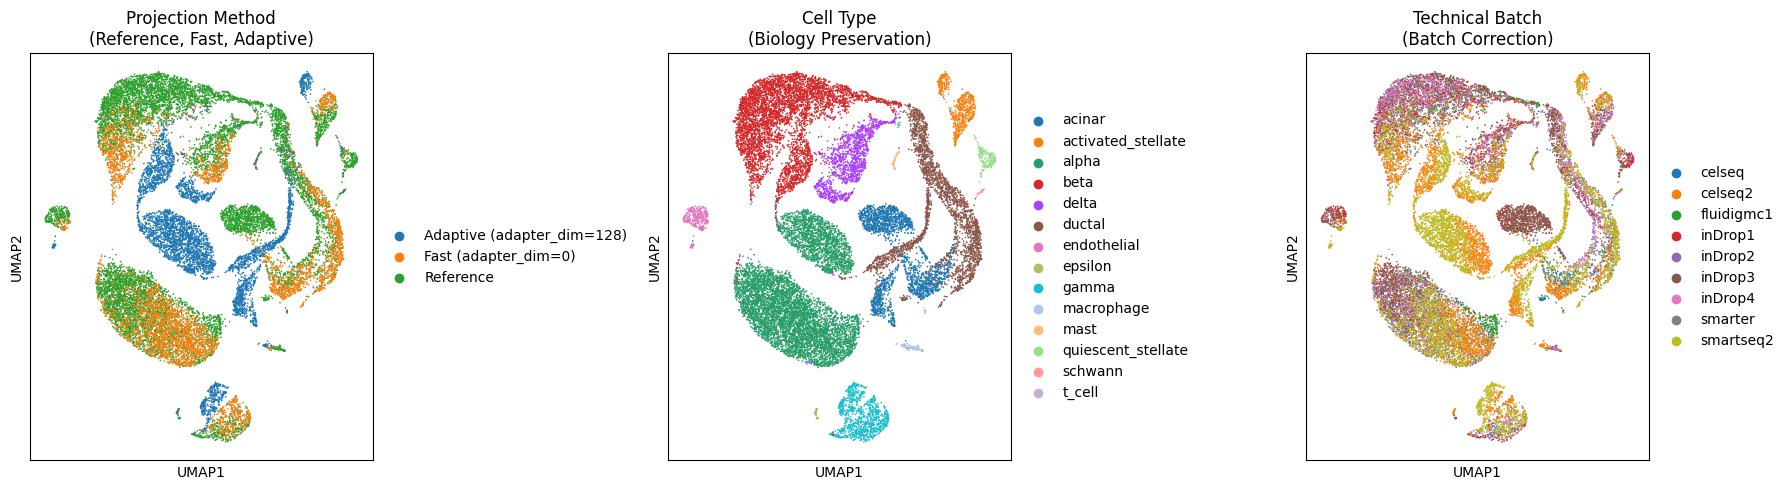


✅ Visualization complete!


In [10]:
# Prepare combined dataset
adata_ref_corrected.obs['projection'] = 'Reference'
adata_query_standard.obs['projection'] = 'Fast (adapter_dim=0)'
adata_query_adaptive.obs['projection'] = 'Adaptive (adapter_dim=128)'

adata_all = sc.concat([
    adata_ref_corrected,
    adata_query_standard,
    adata_query_adaptive
])

# Compute UMAP
print("🔄 Computing UMAP...")
sc.pp.neighbors(adata_all, use_rep='X_ScAdver', n_neighbors=15)
sc.tl.umap(adata_all)
print("✅ UMAP computed!")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata_all, color='projection', ax=axes[0], show=False, 
           title='Projection Method\n(Reference, Fast, Adaptive)', 
           palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

sc.pl.umap(adata_all, color='celltype', ax=axes[1], show=False,
           title='Cell Type\n(Biology Preservation)')

sc.pl.umap(adata_all, color='tech', ax=axes[2], show=False,
           title='Technical Batch\n(Batch Correction)')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

## 📊 Step 6: Detailed Metrics Visualization

Compare metrics side-by-side with bar plots

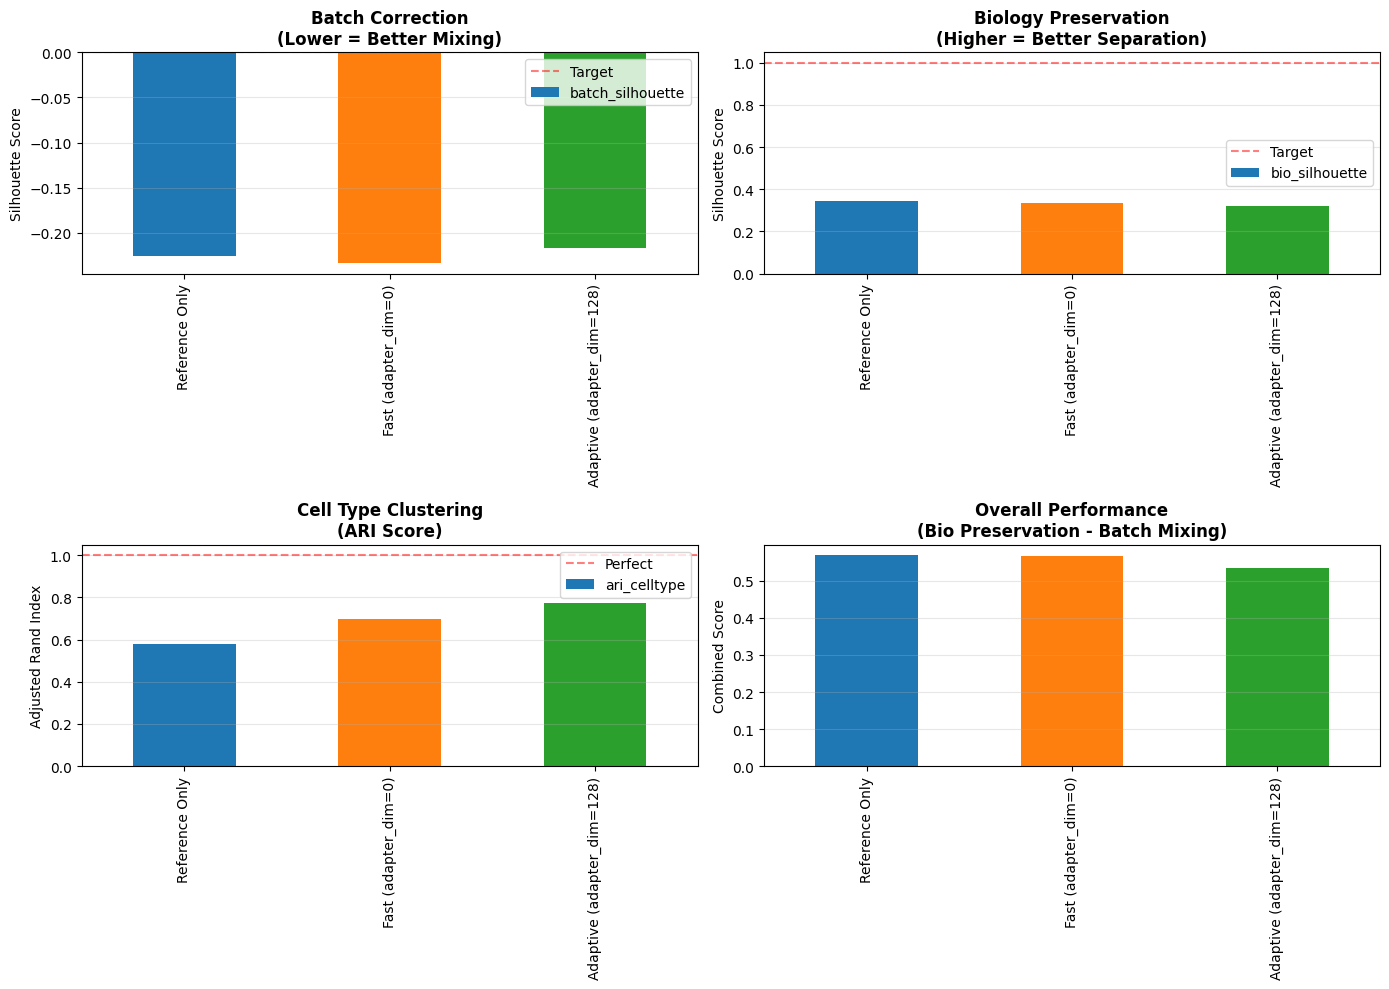


📊 KEY FINDINGS

🔬 Adaptive (adapter_dim=128) vs Fast (adapter_dim=0):
   Batch correction improvement: -7.4%
   Biology preservation improvement: -4.6%

⚠️  Fast mode shows better batch mixing
⚠️  Fast mode shows better biology preservation

💡 Conclusion:
   Fast mode (adapter_dim=0) is sufficient for this scenario


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Batch Correction (lower is better)
ax = axes[0, 0]
metrics_df['batch_silhouette'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Batch Correction\n(Lower = Better Mixing)', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Target')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Biology Preservation (higher is better)
ax = axes[0, 1]
metrics_df['bio_silhouette'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Biology Preservation\n(Higher = Better Separation)', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Target')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Cell Type Clustering (higher is better)
ax = axes[1, 0]
metrics_df['ari_celltype'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Cell Type Clustering\n(ARI Score)', fontsize=12, fontweight='bold')
ax.set_ylabel('Adjusted Rand Index')
ax.set_xlabel('')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Perfect')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 4: Combined Score (higher is better)
ax = axes[1, 1]
metrics_df['combined_score'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Overall Performance\n(Bio Preservation - Batch Mixing)', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Score')
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 KEY FINDINGS")
print("="*70)

# Compare fast vs adaptive
standard_batch = metrics_df.loc['Fast (adapter_dim=0)', 'batch_silhouette']
adaptive_batch = metrics_df.loc['Adaptive (adapter_dim=128)', 'batch_silhouette']
batch_improvement = ((standard_batch - adaptive_batch) / abs(standard_batch)) * 100

standard_bio = metrics_df.loc['Fast (adapter_dim=0)', 'bio_silhouette']
adaptive_bio = metrics_df.loc['Adaptive (adapter_dim=128)', 'bio_silhouette']
bio_improvement = ((adaptive_bio - standard_bio) / standard_bio) * 100

print(f"\n🔬 Adaptive (adapter_dim=128) vs Fast (adapter_dim=0):")
print(f"   Batch correction improvement: {batch_improvement:+.1f}%")
print(f"   Biology preservation improvement: {bio_improvement:+.1f}%")

if adaptive_batch < standard_batch:
    print(f"\n✅ Adaptive mode shows BETTER batch mixing")
else:
    print(f"\n⚠️  Fast mode shows better batch mixing")

if adaptive_bio > standard_bio:
    print(f"✅ Adaptive mode shows BETTER biology preservation")
else:
    print(f"⚠️  Fast mode shows better biology preservation")

print("\n💡 Conclusion:")
if metrics_df.loc['Adaptive (adapter_dim=128)', 'combined_score'] > metrics_df.loc['Fast (adapter_dim=0)', 'combined_score']:
    print("   Adaptive mode (adapter_dim>0) is RECOMMENDED for this domain shift scenario")
else:
    print("   Fast mode (adapter_dim=0) is sufficient for this scenario")
print("="*70)

## 🎯 Summary & Recommendations

### Key Takeaways

**Unified Function: `transform_query_adaptive()`**

ScAdver uses a single function with two modes controlled by `adapter_dim`:

**Fast Mode** (`adapter_dim=0`, default)
- ⚡ Ultra-fast
- 🔄 Direct projection through frozen encoder
- 🎯 Best for: Similar protocols, speed-critical applications
- ✅ Use when: 10X v2 → 10X v3, same lab batches, many query batches
- 💡 No adaptation: `output = encoder(x)`

**Adaptive Mode** (`adapter_dim>0`)
- 🔬 Quality-focused: Trains residual adapter
- 🔄 Residual adapter handles domain shifts: `output = encoder(x) + adapter(x)`
- 🎯 Best for: Large domain shifts, different technologies
- ✅ Use when: 10X → Smart-seq2, cross-species, different tissues
- 💡 Adapter learns to be near-zero if no adaptation needed

### Decision Guide

```python
# For similar protocols (fast)
adata_query = transform_query_adaptive(model, adata_query)  # adapter_dim=0 (default)

# For domain shifts (adaptive)
adata_query = transform_query_adaptive(
    model, 
    adata_query,
    adata_reference=adata_ref[:500],  # Small reference sample
    bio_label='celltype',  # Optional supervision
    adapter_dim=128,  # Enable residual adapter
    adaptation_epochs=50
)
```

### Key Insight

The unified approach is elegant: when you use `adapter_dim>0` but the domains are similar, the adapter automatically learns to output values close to zero, making it equivalent to fast mode. This makes the framework robust and self-adaptive!